```bash
Dow Jones Lasso Analysis:
```

In [1]:
# Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm # color scheme

In [2]:
# Load in the data "
data = pd.read_csv('../multiple_regression/merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


In [3]:
# determining independent and dependent variables used in lasso
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['Dow_Jones']

x = data[independent_variables]
y = data[dependent_variable]

In [4]:
# splitting into test_train, NO SHUFFLE (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

In [5]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [6]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [7]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2

In [9]:
# Results
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 6101.33
Optimal Lambda: 11.71
CPI: 2747.59
Real_IR: -0.00
Unemployment_Rate: -1548.84
GDP_Growth: 368.18
M2_Supply: 1619.06
Federal_Funds_Rate: 0.00


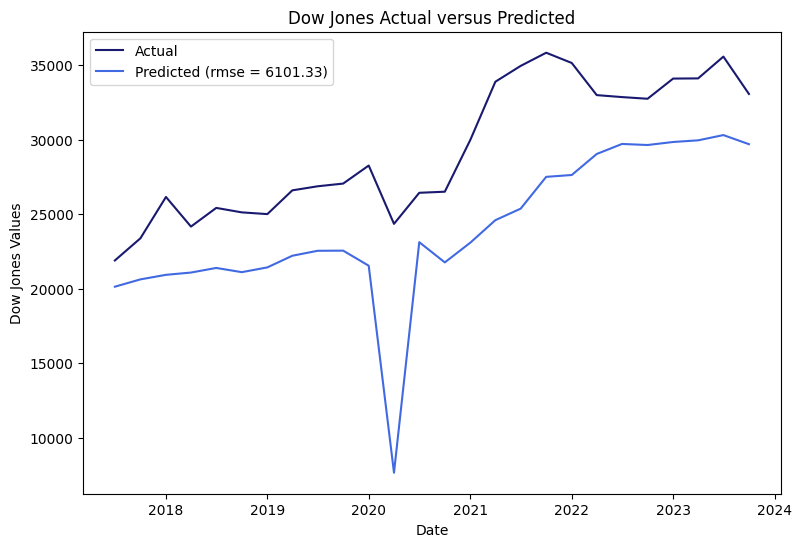

In [10]:
# Actual Versus Predicted Lasso Model
data['Date'] = pd.to_datetime(data['Date']) # converting date to pandas datetime format
dates = data['Date'].iloc[x_test.index] # gets a datatype of all dates based on index

plt.figure(figsize = (9,6))
plt.plot(dates, y_test.values, label = 'Actual', color = 'midnightblue')
plt.plot(dates, y_pred, label = 'Predicted (rmse = 6101.33)', color = 'royalblue')
plt.title('Dow Jones Actual versus Predicted')
plt.xlabel('Date')
plt.ylabel('Dow Jones Values')
plt.legend()
plt.show()

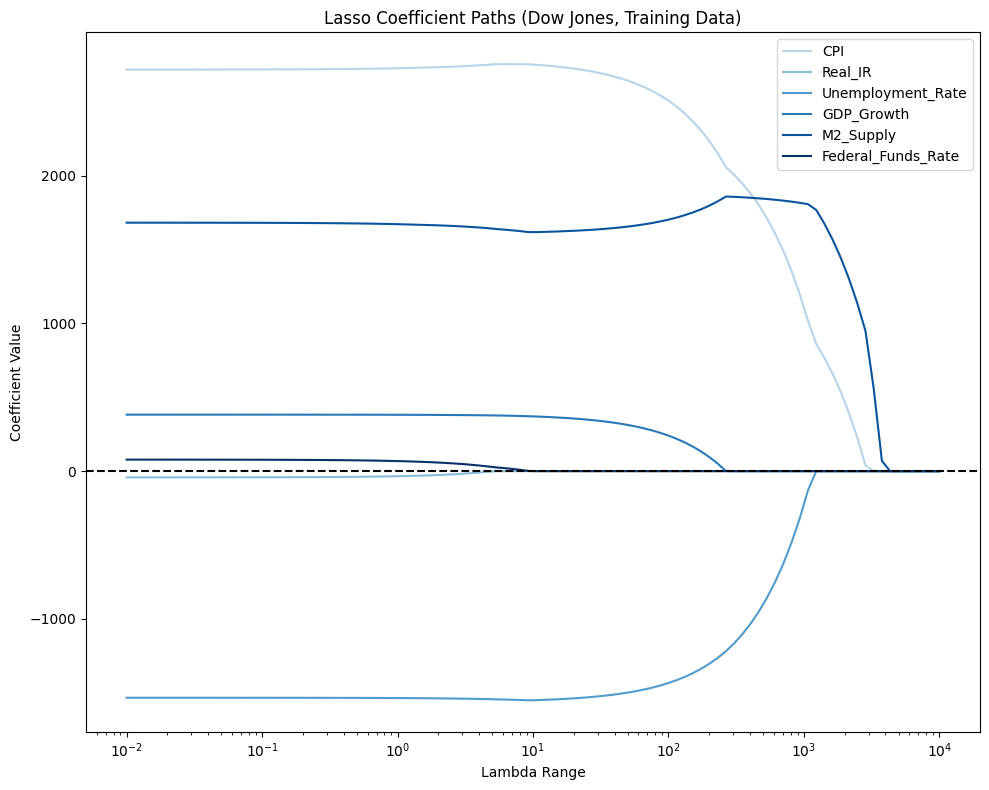

In [11]:
# Plotting Lasso Coefficient 

# colors
colors = cm.Blues(np.linspace(0.3, 1, len(x.columns)))  # light to dark blue

# large range of lambda values
lambdas = np.logspace(-2, 4, 100)

# Calculating the coefficients
coefs = []
for lam in lambdas:
    lasso = Lasso(alpha = lam, max_iter = 10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10, 8))
for i in range(len(x.columns)):  
    coef_path = [coefs[j][i] for j in range(len(coefs))] 
    plt.plot(lambdas, coef_path, label = x.columns[i], color = colors[i])

plt.xscale('log')
plt.xlabel('Lambda Range')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficient Paths (Dow Jones, Training Data)')
plt.axhline(0, color='black', linestyle='--')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

```bash
As lambda increases, M2 money supply, unemployment rate, and CPI are the three indicators with the largest coefficient values and persist the longest before shrinking to zero. This means they are the most important variables in predicting Dow Jones values. On the other hand, GDP growth, Federal Funds Rate, and Real Interest Rate begin with smaller magnitudes and are driven to zero much earlier, indicating they are less influential in the model’s predictions. This is similar to S&P 500 but it takes a larger value of lambda to drive these all to zero.
```

In [12]:
# MLR for MSE comparison

independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['Dow_Jones']

x = data[independent_variables]
x_constant = sm.add_constant(x) # Adding a constant value of x
y = data[dependent_variable]
x_train, x_test, y_train, y_test = train_test_split(x_constant, y, test_size = .20, shuffle = False)

# Running OLS
model = sm.OLS(y_train, x_train).fit()
y_pred = model.predict(x_test)

mse_MLR = mean_squared_error(y_test, y_pred)
rmse_MLR = mse_MLR ** .5
print('MLR MSE:', mse_MLR, '\nLasso MSE:', mse)
print(rmse_MLR)

MLR MSE: 35638656.89952654 
Lasso MSE: 37226194.576148555
5969.812132682781


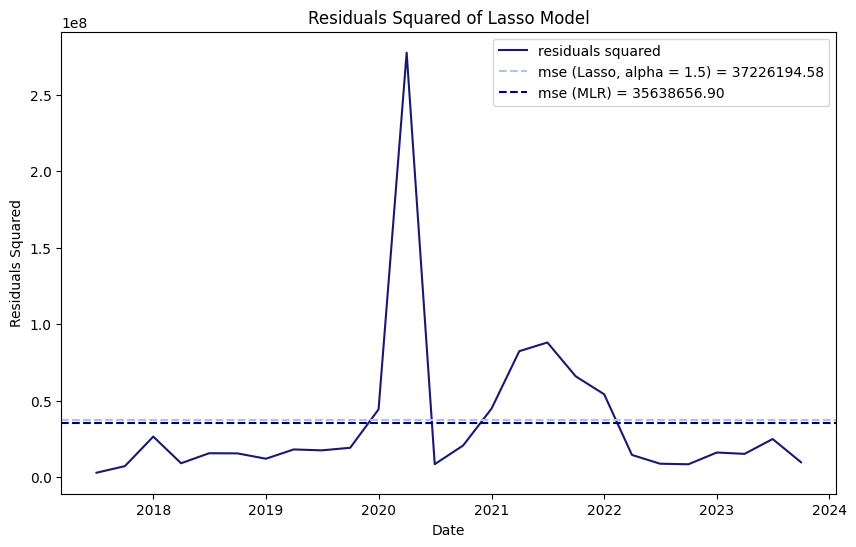

In [16]:
# Residuals (alpha = 1.5)
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize = (10,6))
plt.plot(dates, residuals_squared, color = 'midnightblue', label = 'residuals squared')
plt.axhline(mse, color = 'lightsteelblue', label = 'mse (Lasso, alpha = 11.71) = 37226194.58', linestyle = '--')
plt.axhline(mse_MLR, color = 'navy', label = 'mse (MLR) = 35638656.90', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared of Lasso Model')
plt.legend()
plt.show()

```bash
Using the optimal lambda value of 11.71, we can see that MLR and Lasso MSE do not alter all that much. This implies that the lambda value did not offer much improvement if any at all.

The only difference between MLR and Lasso is alpha and from our coefficient path graph we can see that around a lambda of 300, the only three remaning variables are M2 Money Supply, Unemployment Rate, and CPI. Therefore, we will re-run our lasso using a lambda values of 300 and re-evaluate our model to see if this higher regularization over-penalized the model, or if these are the only three variables that matter.
```

In [43]:
# running lasso with 5 folds on training set and alpha = 300
lasso = LassoCV(cv = 5, random_state = 42, alphas = [300])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [45]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2

In [28]:
# Results
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 6835.16
Optimal Lambda: 300.00
CPI: 2012.70
Real_IR: -0.00
Unemployment_Rate: -1172.87
GDP_Growth: 0.00
M2_Supply: 1857.20
Federal_Funds_Rate: -0.00


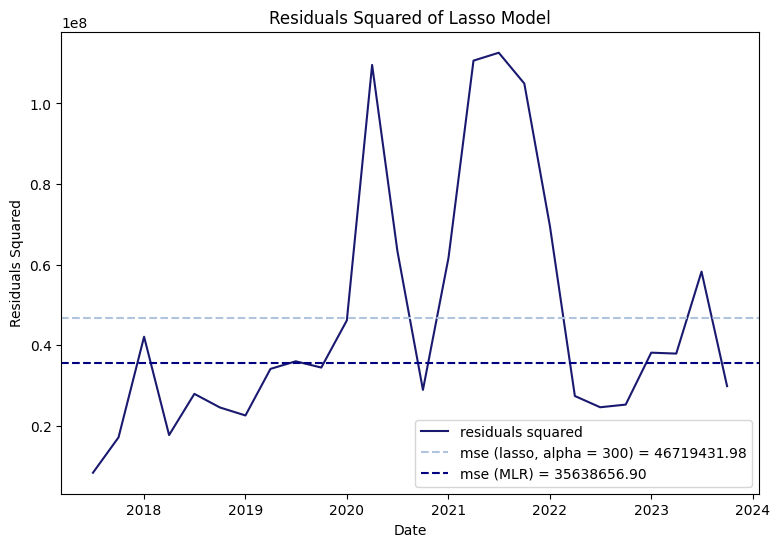

In [46]:
# Residuals
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize = (9,6))
plt.plot(dates, residuals_squared, color = 'midnightblue', label = 'residuals squared')
plt.axhline(new_mse, color = 'lightsteelblue', label = 'mse (lasso, alpha = 300) = 46719431.98', linestyle = '--')
plt.axhline(mse_MLR, color = 'navy', label = 'mse (MLR) = 35638656.90', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared of Lasso Model')
plt.legend()
plt.show()

```bash
Increasing alpha to 300 worsened model performance compared to multiple linear regression. It did not improve generalization, but instead it overly restricted the model, showing that regularization wasn’t needed here to the same degree. This means that yes M2 Money Supply, Unemployment Rate, and CPI are still the three most important macroeconomic factors as they are the ones that take the strongest alpha to approach zero, it does not mean that Federal Funds Rate, GDP Growth, and Real Interest Rate are completeley unimportant to predicting Dow Jones.
```

In [47]:
# running lasso with 5 folds on training set and alpha = 0 to show that it is the same as MLR

# CHAT GPT REFRENCE - GET RID OF WARNINGS
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  

lasso = LassoCV(cv = 5, random_state = 42, alphas = [0])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2
print('MLR MSE:', mse_MLR, '\nLasso MSE:', new_mse)

MLR MSE: 35638656.89952654 
Lasso MSE: 35638656.89953238


```bash
When the alpha is at zero, lasso is equal to Multiple Linear Regression. Confirmed with the same outputed MSE values. 
```

```bash
While Lasso did not drastically improve predictive performance compared to multiple linear regression, it was highly effective for feature selection. By increasing the regularization parameter (lambda), Lasso shrank the coefficients of less important variables (like GDP Growth, Federal Funds Rate, and Real Interest Rate) toward zero much earlier. This reveals that the most influential predictors of the Dow Jones index are M2 Money Supply, Unemployment Rate, and CPI, as they retained strong coefficient values the longest.

Thus, Lasso provides valuable insight into which macroeconomic variables contribute most to modeling the Dow Jones, even if the prediction error itself is not significantly reduced.
```